In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import string
from scipy import stats
from collections import Counter
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

PUNCT_TO_REMOVE = string.punctuation
lemmatizer = WordNetLemmatizer()
SEED=2020
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
le = LabelEncoder()

In [2]:
df= pd.read_csv(r'odessa_apts_prices_en_2020.csv')
df = df.drop_duplicates()
numcol = df.select_dtypes(include=[np.number]).columns.drop('price')
catcol = df.select_dtypes(include=[np.object]).columns

<ipython-input-2-a493866cfa43>:4: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  catcol = df.select_dtypes(include=[np.object]).columns


In [3]:
df.describe(percentiles=[.25, .5, .75, .9544]).T  ## z-score +/- 2 sigma


,count,mean,std,min,25%,50%,75%,95.4%,max
price,6657.0,65688.417176,75745.638192,550.0,35000.0,48490.0,71000.0,170000.000,2000000.0
rooms,6514.0,1.948726,0.917349,1.0,1.0,2.0,3.0,4.000,4.0
floor,6657.0,6.656001,5.436315,1.0,2.0,5.0,9.0,18.000,26.0
floors,6657.0,11.894697,7.098436,1.0,5.0,10.0,17.0,25.000,30.0
area,6641.0,65.485624,39.393466,10.0,42.5,58.0,76.0,132.216,800.0


In [4]:

df_train, df_test = train_test_split(df, test_size=0.3, random_state=SEED)


In [5]:
def imputer(df):
    '''*NaN values imputainon to mode for cats and median for nums*'''
    for col in df:
        if col in catcol:
            df.loc[:, col]=df.loc[:, col].fillna(df.loc[:, col].mode()[0])
        else: df.loc[:, col].fillna(df.loc[:, col].median(), inplace=True)
    return df

df_train = imputer(df_train)
df_test = imputer(df_test)

/home/user/.local/lib/python3.8/site-packages/pandas/core/series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
/home/user/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/user/.local/lib/python3.8/site-packages/pandas/core/series.py:4460: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

In [6]:
df_train.sample(10)


,price,district,rooms,floor,floors,area,type,cond,walls,desc
6101,80000.0,Primorsky,1.0,16,24.0,48.0,New,Renovation,Foam concrete,"in a new house in Arcadia, Author's project, v..."
399,44500.0,Primorsky,1.0,9,12.0,42.0,New,After builders,Brick,Apartment in 31 pearls at 10 stations of the B...
4421,34000.0,Kievsky,1.0,10,16.0,36.0,New,Renovation,Monolith,w / c Raduzhny-1. The apartment is renovated. ...
89,43000.0,Suvorovsky,3.0,2,5.0,82.0,Moscow,Renovation,Block-brick,"Renovated apartment, huge studio kitchen, sepa..."
5209,53000.0,Malinovsky,1.0,10,14.0,49.0,New,Renovation,Brick,"Fully renovated, built-in kitchen, appliances,..."
2401,37000.0,Suvorovsky,2.0,9,9.0,46.0,Kharkiv,Renovation,Block-brick,New rented house of VIP - level in a quiet res...
481,53000.0,Primorsky,1.0,18,24.0,40.0,New,Renovation,Brick,"32 Pearl. Modern renovation, only legal."
2855,43000.0,Suvorovsky,1.0,4,4.0,39.0,Special project,Author's design,Aerated concrete,"Residential complex ""SMART"" Two-level apartmen..."
6446,46800.0,Primorsky,1.0,4,6.0,39.0,Under construction,After builders,Expanded clay-concrete,Apartment in a small apartment building under ...
1351,83000.0,Malinovsky,2.0,1,10.0,80.0,New,Renovation,Brick,The apartment has a correct layout. Total area...


In [7]:
def encoder(df):
    district_category = {'Malinovsky':1, 'Kievsky':2, 'Primorsky':3, 'Suvorovsky':4}
    # Mapping 'district' to group
    df.loc[:, 'district']=df.loc[:, 'district'].map(district_category)
    
    # Bundle rare descriptions with 'Other' category
    df.loc[:,'type'] = df.loc[:,'type'].replace(['Old fund', 'Czech', 'Khrushchevka', 'Stalinka', 'Cellular', 'Belgian', 'Kharkiv', 
                                       'Under construction', 'Moscow', 'Guest', 'Jugoslavsky', 'Private house', 'A small family', 'Renovation',
                                    'After overhaul', 'After builders', 'Residential clean', 'After makeup'], 'Other')
    type_category = {'New ':1, 'Special project':2, 'Other':3}
    df.loc[:, 'type'] = df.loc[:,'type'].map(type_category)
    
    # Bundle rare condition with new categories
    df.loc[:,'cond'] = df.loc[:,'cond'].replace(['Renovation', 'After overhaul', 'After makeup', "Author's design", 'Design Classic', 'Modern design', 'NaN'], 'After renovation') 
    df.loc[:,'cond'] = df.loc[:,'cond'].replace(['After builders', 'Brick', 'Block-brick', "Monolith", 'Blocky', 'Expanded clay-concrete', 'House under construction', 
                                    'Aerated concrete', 'Shell rock', 'Building materials'], 'After builders') 
    df.loc[:,'cond'] = df.loc[:,'cond'].replace(['Need. in cap. renovation', 'Need. in cosm. renovation', 'Need. in tech. renovation'], 'Need renovation') 
    cond_category = {'After renovation':1, 'After builders':2, 'Need renovation':3, 'Residential clean':4}
    df.loc[:,'cond']= df.loc[:,'cond'].map(cond_category)
    
    # Bundle rare walls with new categories
    df.loc[:,'walls'] = df.loc[:,'walls'].replace(['Metal-plastic', 'Metalwork', 'Plastic', "Wood", 'Mixed', 'Reed, dranka ', 'NaN'], 'Other')
    walls_category = {'Brick':1, 'Silicate brick':1, 'Monolith':2, 'Concrete':2, 'Reinforced concrete':2, 'Shell rock':3, 'Shell brick':3, 'Block-brick':4, 'Blocky':4,
                     'Panel': 5, 'Aerated concrete':6, 'Foam concrete':6, 'Expanded clay-concrete': 6, 'Other':7}
    df.loc[:,'walls']=df.loc[:,'walls'].map(walls_category)
    

    return(df)

df_train = encoder(df_train)
df_test = encoder(df_test)

/home/user/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [8]:
df_train.sample(20)


,price,district,rooms,floor,floors,area,type,cond,walls,desc
3934,10500.0,4,1.0,2,5.0,58.0,2,1,4,"The room is after a cosmetic repair, IGO, wate..."
6139,47000.0,2,3.0,19,24.0,92.0,1,2,1,"Makarenko corner of Lviv. 19th floor, open pla..."
5007,45000.0,2,2.0,9,11.0,70.0,1,2,1,Author's studio. Brick new building. 2-circuit...
1007,160000.0,3,2.0,8,23.0,58.0,2,1,2,"The apartment is fully renovated, windows over..."
4261,100000.0,3,4.0,1,1.0,75.0,3,3,3,"Perhaps for an office, a basement and a front ..."
765,53000.0,2,3.0,5,10.0,63.0,3,1,5,"Spacious Czech with separate rooms, air condit..."
4687,160000.0,3,3.0,2,4.0,78.0,3,1,3,"Renovation, all furniture and appliances remai..."
3174,40000.0,3,2.0,2,14.0,52.0,2,4,1,"House built ""Stikon"". Front door for four apar..."
1995,17000.0,3,1.0,2,2.0,43.0,3,4,3,The apartment is in a residential condition. Y...
1903,57300.0,3,2.0,21,21.0,57.0,1,2,2,"Lcd Literary 2, house delivery in March 2021. ..."


<AxesSubplot:xlabel='area', ylabel='price'>

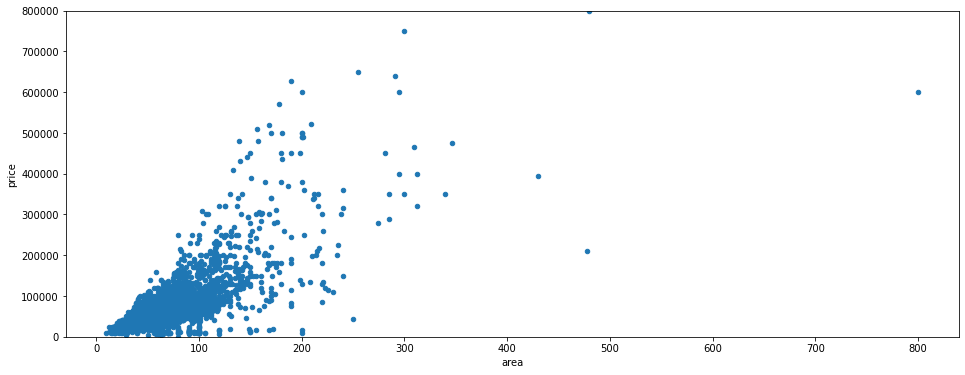

In [9]:
df_train.plot.scatter(x='area', y='price', figsize=(16, 6), ylim=(0,800000))


In [10]:
def one_value_cols_remover(df):
    one_value_cols = [col for col in df.columns if df[col].nunique() <= 1]
    df.drop(one_value_cols, axis=1, inplace=True)
    print ('One value cols removed')
    return df

df_train = one_value_cols_remover(df_train)
df_test = one_value_cols_remover(df_test)

One value cols removed
One value cols removed
/home/user/.local/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:



def drop_outliers(df):
    #     '''drop outliers with z-score over 99.9%'''
#     z = np.abs(stats.zscore(df._get_numeric_data()))
#     df= df[(z < 3).all(axis=1)].reset_index(drop=True)
    df= df.loc[(df.price<170000) & (df.area<132)] ## as per 95.44% percentile (+/- 2 sigma)
    """
    Returns clear df without outliers based on IQR method
    corresponding to the observations containing more than 2 outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in ['price', 'rooms', 'floor', 'floors', 'area']:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.2 * IQR ## can be increased to 1.7 sometimes
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > 2)
    print(df.loc[multiple_outliers][['price', 'rooms', 'floor', 'floors', 'area']]) # Show the outliers rows
    # Drop outliers
    df = df.drop(multiple_outliers, axis = 0).reset_index(drop=True)
    print('Outliers dropped')
    return df

df_train = drop_outliers(df_train)
df_test = drop_outliers(df_test)

         price  rooms  floor  floors    area
6698  110000.0    4.0     21    24.0  115.00
353   110000.0    3.0     22    23.0  107.00
1033  145000.0    3.0     18    22.0  118.00
4220  110000.0    3.0     24    25.0  108.00
6670  115000.0    3.0     25    25.0  123.00
698   116000.0    3.0     18    24.0  111.00
5416  108000.0    4.0     18    25.0  106.40
6365  145200.0    3.0     20    23.0  121.20
3323  165000.0    3.0     18    24.0  121.55
Outliers dropped
        price  rooms  floor  floors   area
113  145000.0    3.0     20    24.0  107.0
Outliers dropped


<AxesSubplot:xlabel='area', ylabel='price'>

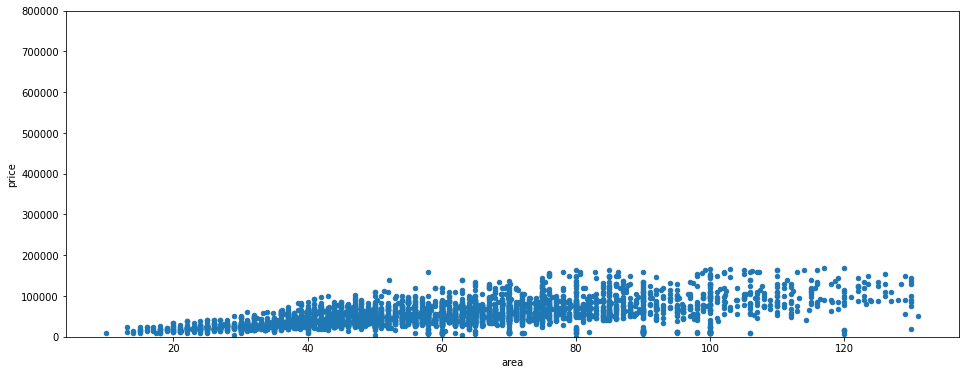

In [12]:
df_train.plot.scatter(x='area', y='price', figsize=(16, 6), ylim=(0,800000))


In [13]:
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def desc_features(df):
    '''return new features based on text desc feature'''
#     pd.set_option('mode.chained_assignment', None)  ## new features based on old
# #     df['desc_len'] = df['desc'].apply(lambda x: len(str(x)))
#     df["desc"] = df["desc"].apply(lambda text: remove_punctuation(text))
#     df["desc"] = df["desc"].apply(lambda text: lemmatize_words(text))
#     df['near_sea']=df['desc'].str.contains('sea').astype(int)
#     df['near_school']=df['desc'].str.contains('school').astype(int)
#     df['near_kindergarten']=df['desc'].str.contains('kindergarten').astype(int)          
#     df['near_park']=df['desc'].str.contains('park').astype(int)
#     df['parking']=df['desc'].str.contains('parking').astype(int)
#     df['new']=df['desc'].str.contains('new').astype(int)
# #     df['with_builtin']=df['desc'].str.contains('builtin').astype(int)
#     df['after_renovation']=df['desc'].str.contains('renovation', 'renovated').astype(int)
# #     df['large']=df['desc'].str.contains('large', 'spacious').astype(int)
# #     df['good']=df['desc'].str.contains('good', 'excellent').astype(int)
    df.drop('desc', axis=1, inplace=True)
    return df

df_train = desc_features(df_train)
df_test = desc_features(df_test)